In [1]:
from multiatomic import *

### Example 4: $\mathrm{H_2O}$, Interpolated, Velocity-Verlet

In [2]:
import water_pot
print(water_pot.double_precision_pots.__doc__)

result = double_precision_pots(rij1,rij2,rij3)

Wrapper for ``double_precision_pots``.

Parameters
----------
rij1 : input float
rij2 : input float
rij3 : input float

Returns
-------
result : float



In [3]:
def unit_vector(vector):
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

In [4]:
def waterInterpolated(atoms, params) -> float:
    if (debugMode):
        if (not isinstance(atoms, np.ndarray)):
            raise RuntimeError("Invalid atoms. Must be a NumPy array.")
        if (len(atoms) != 3):
            raise RuntimeError("Invalid no. atoms. Must be 3.")
        for atom in atoms:
            if (not isinstance(atom, Atom)):
                raise RuntimeError("Invalid atoms. Must be Atom type.")
    rij1 = atoms[1].getPosition() - atoms[0].getPosition()
    rij2 = atoms[1].getPosition() - atoms[2].getPosition()
    rij3 = angle_between(rij1, rij2)
    result = water_pot.double_precision_pots(np.linalg.norm(rij1), np.linalg.norm(rij2), rij3)
    return result

In [5]:
hMass = 1.00784 # Dalton
oMass = 15.994 # Dalton
atom1 = Atom("Atom1", hMass, np.array([1.8, 0.0, 0.0]), np.array([0.0, 0.0, 0.0]), np.array([0.0, 0.0, 0.0]))
atom2 = Atom("Atom2", oMass, np.array([0.0, 0.0, 0.0]), np.array([0.0, 0.0, 0.0]), np.array([0.0, 0.0, 0.0]))
atom3 = Atom("Atom3", hMass, np.array([0.0, 1.8, 0.0]), np.array([0.0, 0.0, 0.0]), np.array([0.0, 0.0, 0.0]))
atoms = np.array([atom1, atom2, atom3])
potential = Potential(waterInterpolated)
molecularSystem = MolecularSystem(atoms, potential)
integratorName = "velocityVerlet"
filepath = thisdir / 'temp_h2o_interp_vv'
N = 100000
deltaT = 0.001
startTime = time.time()
molecularSystem = simulate(filepath, molecularSystem, integratorName, N, deltaT)
endTime = time.time()

In [6]:
appath = filepath / 'AtomicPositions'
aspath = filepath / 'AtomicSeparations.csv'
avdir = filepath / 'AtomicVelocities'
enpath = filepath / 'Energies.csv'

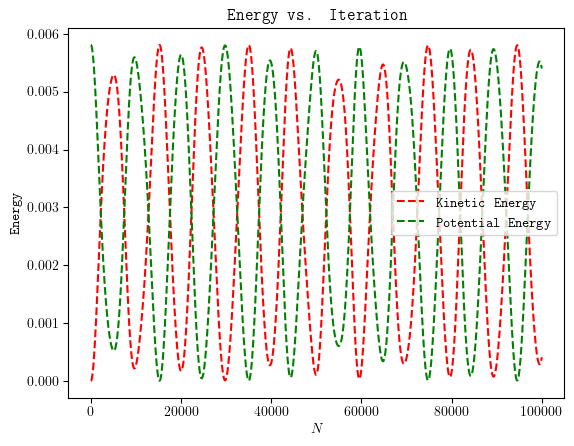

In [7]:
plotEnergies(enpath, "kp")

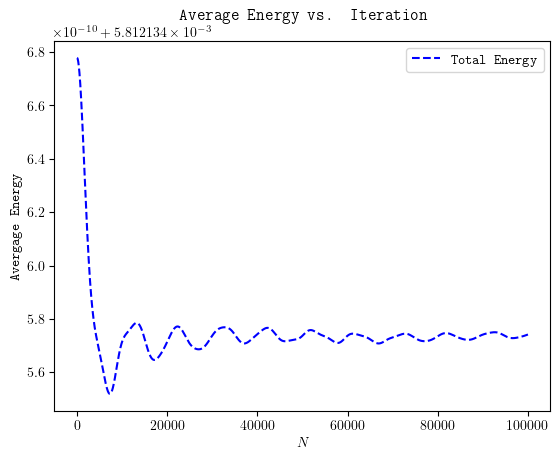

In [8]:
plotRunningAverageEnergies(enpath, "total")

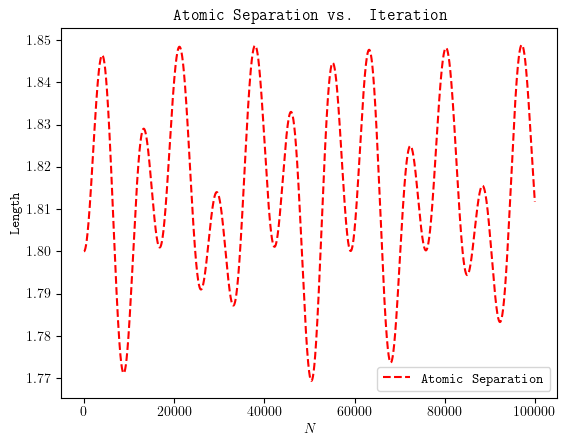

In [9]:
plotAtomicSeparations(aspath, "Atom1-Atom2")

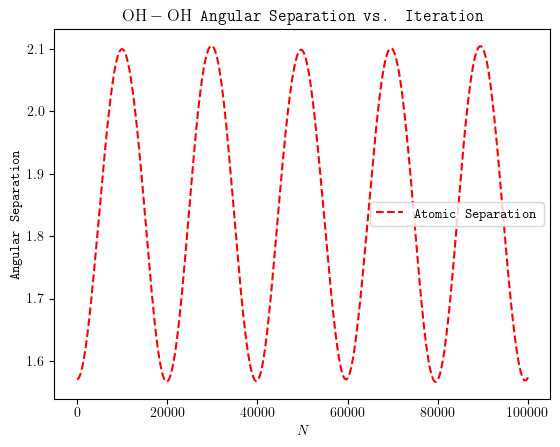

In [10]:
# Plot OH-OH Angular Separation
h1pData = pd.read_csv(appath / "Atom1.csv")
opData = pd.read_csv(appath / "Atom2.csv")
h2pData = pd.read_csv(appath / "Atom3.csv")
N = len(h1pData.index)
angularSeparations = np.zeros(N)
for i in range(0, N, 1):
    rij1 = opData.iloc[i].to_numpy() - h1pData.iloc[i].to_numpy()
    rij2 = opData.iloc[i].to_numpy() - h2pData.iloc[i].to_numpy()
    angularSeparations[i] = angle_between(rij1, rij2)
xs = np.arange(0, N, 1)
plt.plot(xs, angularSeparations, "r--", label = "Atomic Separation")
plt.xlabel("$N$")
plt.ylabel("Angular Separation")
plt.legend()
plt.title("$\mathrm{OH-OH}$ Angular Separation vs. Iteration")
plt.savefig(filepath / 'AngularSeparationVsIteration')
plt.show()

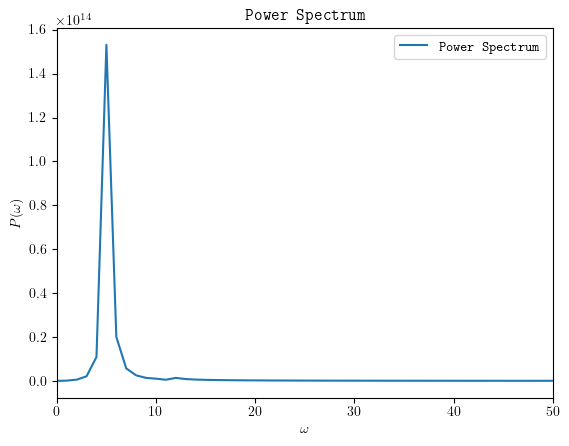

In [11]:
fileNames = molecularSystem.getAtomNames()
vacf = calculateVacf(avdir, fileNames)
powerSpectrum = calculatePowerSpectrum(vacf)
plotPowerSpectrum(avdir, powerSpectrum, [0.0, 50.0], False)

In [12]:
atomicSeparations = pd.read_csv(aspath)
energies = pd.read_csv(enpath)
vv = energies
print("Simulation Time:", round(endTime - startTime, 4), "seconds")
print("Initial Total Energy:", round(energies["TE"].iat[0], 4), "Hartree")
print("Final Total Energy:", round(energies["TE"].iat[-1], 4), "Hartree")
print("Average Total Energy:", round(np.mean(energies["TE"]), 4), u"\u00B1", round(np.std(energies["TE"]), 4), "Hartree")
print("Average OH Atomic Separation:", round(np.mean(atomicSeparations["Atom1-Atom2"]), 4), u"\u00B1", round(np.std(atomicSeparations["Atom1-Atom2"]), 4), "Bohr")
print("Average OH Angular Separation:", round(np.mean(angularSeparations), 4), u"\u00B1", round(np.std(angularSeparations), 4), "radians")

Simulation Time: 254.9939 seconds
Initial Total Energy: 0.0058 Hartree
Final Total Energy: 0.0058 Hartree
Average Total Energy: 0.0058 ± 0.0 Hartree
Average OH Atomic Separation: 1.8139 ± 0.0207 Bohr
Average OH Angular Separation: 1.837 ± 0.189 radians
